In [2]:
import pandas as pd

# Cargar el dataset
df = pd.read_excel("Volve production data.xlsx", sheet_name="Daily Production Data")# Contar pozos diferentes
num_pozos = df["NPD_WELL_BORE_NAME"].nunique()
print(f"Número de pozos diferentes: {num_pozos}")

# Ver la lista de pozos únicos (opcional)
pozos_unicos = df["NPD_WELL_BORE_NAME"].unique()
print(pozos_unicos)



Número de pozos diferentes: 7
['15/9-F-1 C' '15/9-F-11' '15/9-F-12' '15/9-F-14' '15/9-F-15 D' '15/9-F-4'
 '15/9-F-5']


In [3]:
df.columns

Index(['DATEPRD', 'WELL_BORE_CODE', 'NPD_WELL_BORE_CODE', 'NPD_WELL_BORE_NAME',
       'NPD_FIELD_CODE', 'NPD_FIELD_NAME', 'NPD_FACILITY_CODE',
       'NPD_FACILITY_NAME', 'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE',
       'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS',
       'AVG_CHOKE_SIZE_P', 'AVG_CHOKE_UOM', 'AVG_WHP_P', 'AVG_WHT_P',
       'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL',
       'BORE_WI_VOL', 'FLOW_KIND', 'WELL_TYPE'],
      dtype='object')

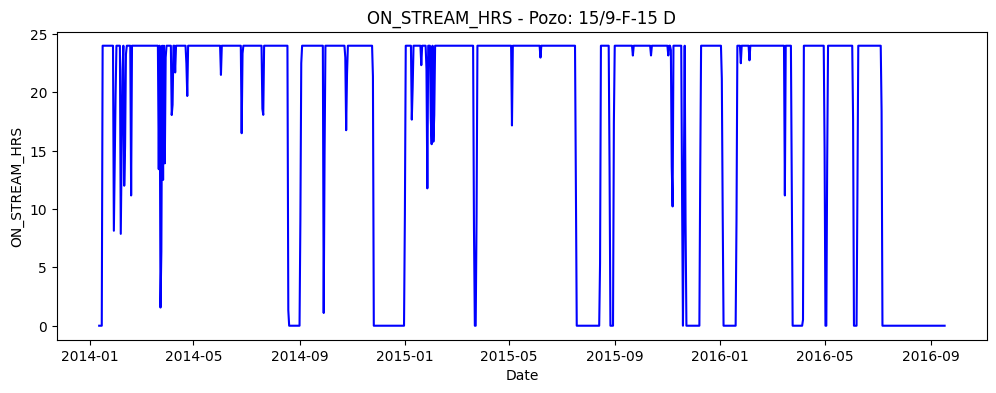

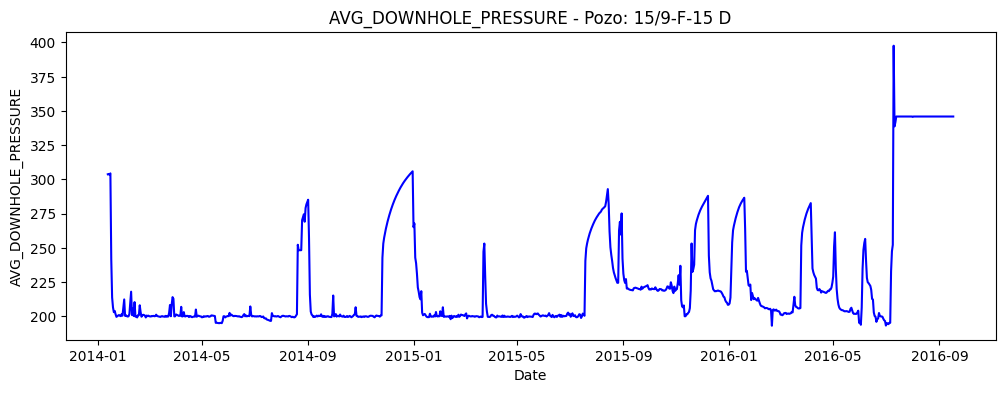

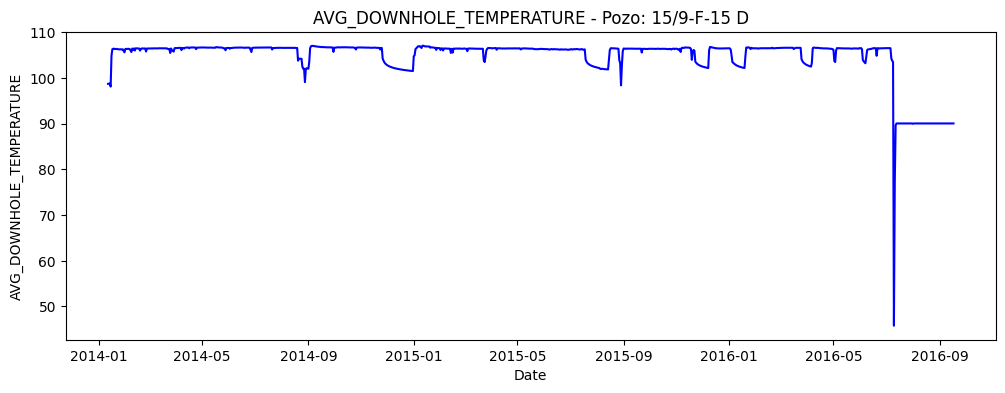

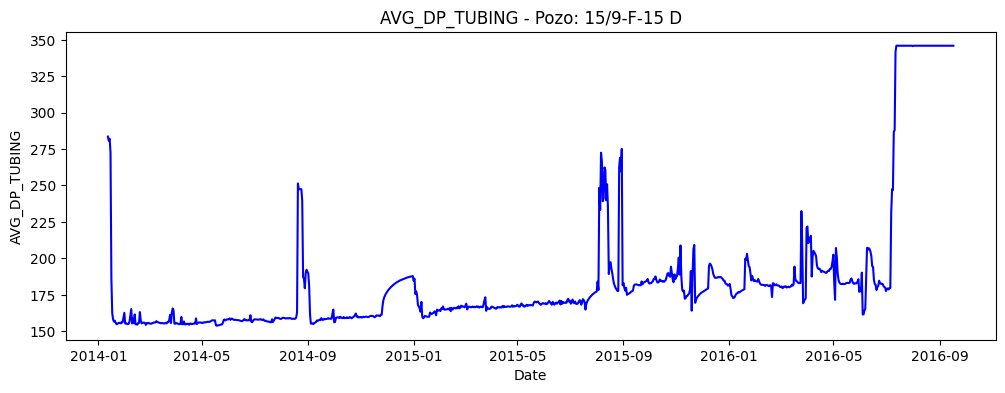

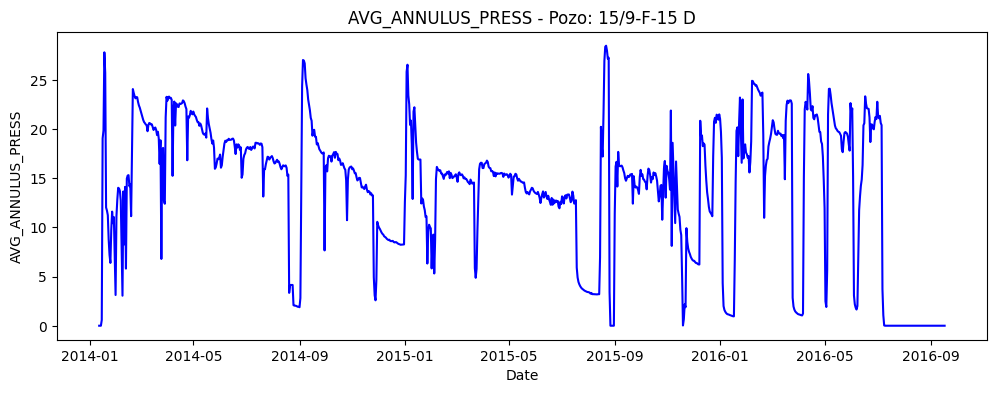

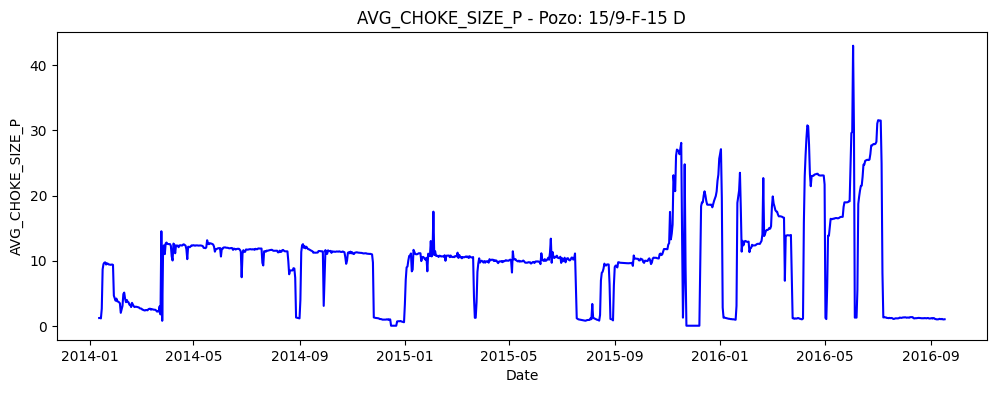

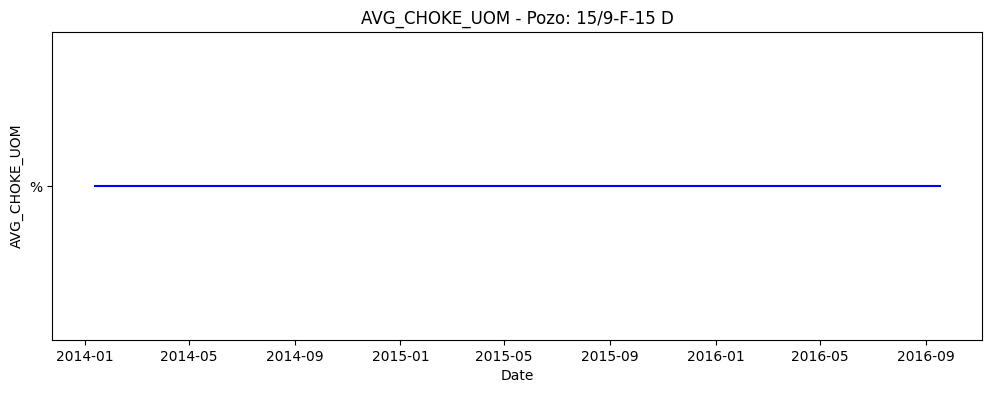

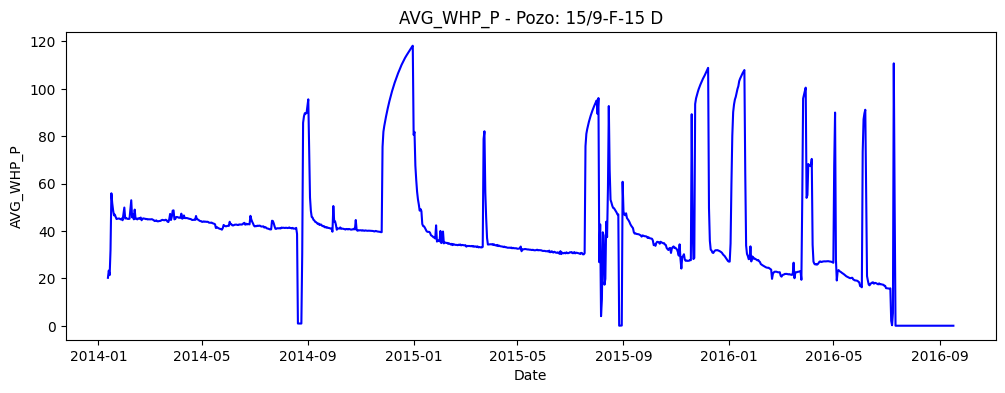

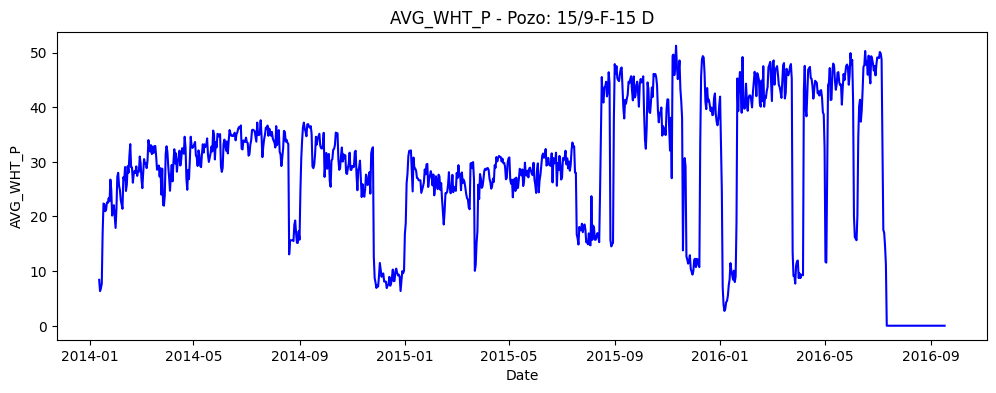

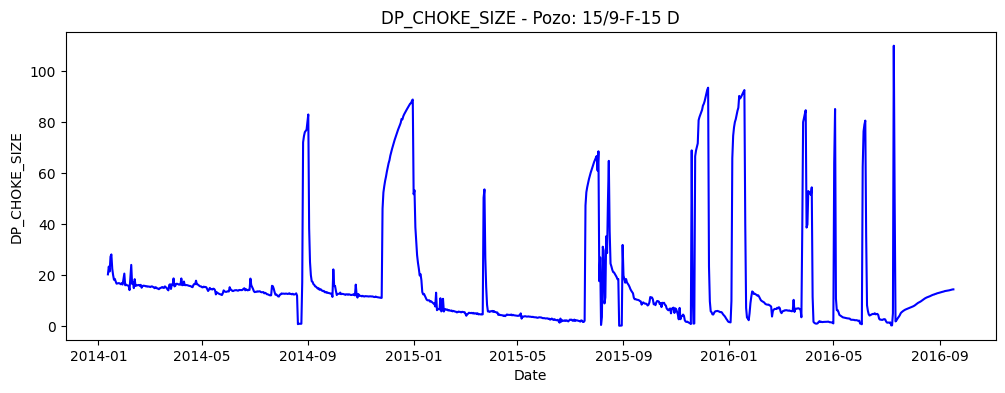

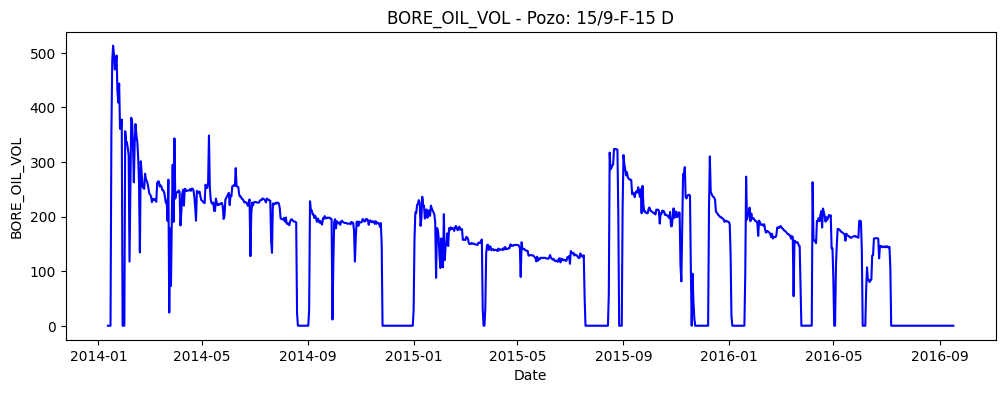

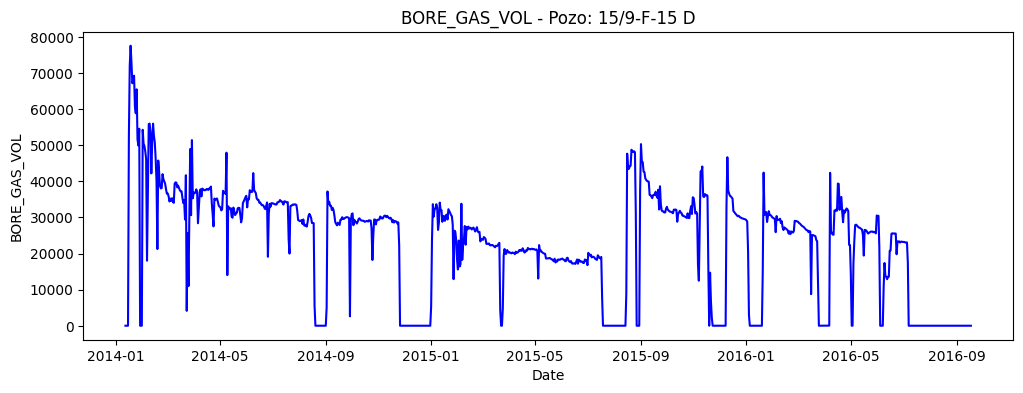

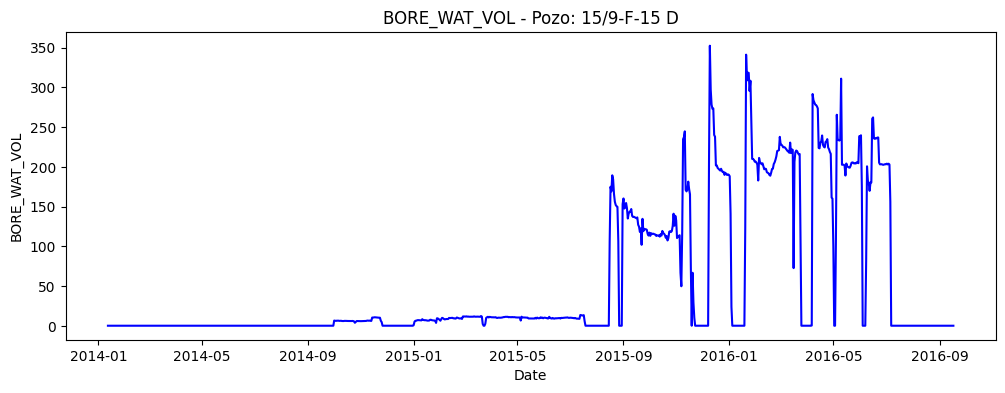

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrar solo el pozo deseado y crear copia
pozo = "15/9-F-15 D"
df_pozo = df[df["NPD_WELL_BORE_NAME"] == pozo].copy()

# Asegurarse de que la fecha es tipo datetime
df_pozo["DATEPRD"] = pd.to_datetime(df_pozo["DATEPRD"])

# Variables específicas a graficar
variables = [
    'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE',
    'AVG_DP_TUBING', 'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_CHOKE_UOM',
    'AVG_WHP_P', 'AVG_WHT_P', 'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL',
    'BORE_WAT_VOL',
]

# Graficar cada variable por separado
for var in variables:
    plt.figure(figsize=(12, 4))
    plt.plot(df_pozo["DATEPRD"], df_pozo[var], color='blue')
    plt.title(f"{var} - Pozo: {pozo}")
    plt.xlabel("Date")
    plt.ylabel(var)
    plt.grid(False)
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

# ---------- Cargar datos y filtrar pozos ----------
df = pd.read_excel("Volve production data.xlsx", sheet_name="Daily Production Data")
pozos_validos = ["15/9-F-1 C","15/9-F-11","15/9-F-12","15/9-F-14","15/9-F-15 D"]
df = df[df["NPD_WELL_BORE_NAME"].isin(pozos_validos)]
df = df[df["AVG_DOWNHOLE_PRESSURE"].notna() & (df["AVG_DOWNHOLE_PRESSURE"] > 1)]
df["DATEPRD"] = pd.to_datetime(df["DATEPRD"])
df = df.sort_values(by=["NPD_WELL_BORE_NAME", "DATEPRD"])

# ---------- Interpolación ----------
columns_to_fill = [
    'ON_STREAM_HRS', 'AVG_DOWNHOLE_PRESSURE', 'AVG_DOWNHOLE_TEMPERATURE', 'AVG_DP_TUBING',
    'AVG_ANNULUS_PRESS', 'AVG_CHOKE_SIZE_P', 'AVG_WHP_P', 'AVG_WHT_P',
    'DP_CHOKE_SIZE', 'BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL'
]
for col in columns_to_fill:
    df[col] = df[col].interpolate(method='linear', limit_direction='both').bfill().ffill()

# ---------- One-hot encoding del pozo ----------
df = pd.get_dummies(df, columns=["NPD_WELL_BORE_NAME"], prefix="pozo")

# ---------- Eliminar columnas irrelevantes ----------
to_drop = ["WELL_BORE_CODE", "NPD_FIELD_NAME", "NPD_FIELD_CODE", "NPD_FACILITY_CODE",
           "NPD_FACILITY_NAME", "BORE_WI_VOL", "AVG_CHOKE_UOM", "FLOW_KIND", "WELL_TYPE"]
df = df.drop(columns=to_drop, errors='ignore')

# ---------- Definir pozos ----------
pozo_fuentes = ["15/9-F-1 C","15/9-F-11","15/9-F-12","15/9-F-14"]   # Pozos para pretraining
pozo_destino = "15/9-F-15 D"                            # Pozo para fine-tuning y test

# Pretraining set (multi-pozo)
cols_train = [f"pozo_{p}" for p in pozo_fuentes]
df_pretrain = df[df[cols_train].any(axis=1)].copy()

# Fine-tuning/Test set (pozo destino)
df_finetune = df[df[f"pozo_{pozo_destino}"] == 1].copy()

# ---------- Escalado ----------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_pretrain = df_pretrain.drop(columns=["DATEPRD", "AVG_DOWNHOLE_PRESSURE"]).values
y_pretrain = df_pretrain["AVG_DOWNHOLE_PRESSURE"].values

X_finetune = df_finetune.drop(columns=["DATEPRD", "AVG_DOWNHOLE_PRESSURE"]).values
y_finetune = df_finetune["AVG_DOWNHOLE_PRESSURE"].values

X_pretrain_scaled = scaler_X.fit_transform(X_pretrain)
y_pretrain_scaled = scaler_y.fit_transform(y_pretrain.reshape(-1, 1))

X_finetune_scaled = scaler_X.transform(X_finetune)
y_finetune_scaled = scaler_y.transform(y_finetune.reshape(-1, 1))

# ---------- Crear secuencias ----------
seq_len = 14      # entrada al encoder
pred_len = 14     # salida esperada
label_len = 14    # contexto del decoder

def create_sequences(X, Y, seq_len=14, pred_len=14):
    X_seq, Y_seq = [], []
    for i in range(len(X) - seq_len - pred_len):
        x = X[i : i + seq_len]
        y = Y[i + seq_len : i + seq_len + pred_len]
        X_seq.append(x)
        Y_seq.append(y)
    return np.array(X_seq), np.array(Y_seq)

# Pretraining
X_pretrain_seq, Y_pretrain_seq = create_sequences(X_pretrain_scaled, y_pretrain_scaled, seq_len, pred_len)

# Fine-tuning (pozo destino → se divide en train/val/test)
X_ft_seq, Y_ft_seq = create_sequences(X_finetune_scaled, y_finetune_scaled, seq_len, pred_len)

n = len(X_ft_seq)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

x_finetune_train, y_finetune_train = X_ft_seq[:train_end], Y_ft_seq[:train_end]
x_finetune_val, y_finetune_val     = X_ft_seq[train_end:val_end], Y_ft_seq[train_end:val_end]
x_finetune_test, y_finetune_test   = X_ft_seq[val_end:], Y_ft_seq[val_end:]

# ---------- Tensores ----------
x_pretrain, y_pretrain = torch.tensor(X_pretrain_seq).float(), torch.tensor(Y_pretrain_seq).float()
x_ft_train, y_ft_train = torch.tensor(x_finetune_train).float(), torch.tensor(y_finetune_train).float()
x_ft_val, y_ft_val     = torch.tensor(x_finetune_val).float(),   torch.tensor(y_finetune_val).float()
x_ft_test, y_ft_test   = torch.tensor(x_finetune_test).float(),  torch.tensor(y_finetune_test).float()

# ---------- Dataset ----------
class InformerDataset(Dataset):
    def __init__(self, x_data, y_data, label_len):
        self.x_data = x_data
        self.y_data = y_data
        self.label_len = label_len

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        enc_x = self.x_data[idx]  # [seq_len, input_dim]
        dec_len = self.y_data.shape[1]
        input_dim = enc_x.shape[1]

        dec_x = torch.zeros(self.label_len + dec_len, input_dim).float()
        dec_x[:self.label_len] = enc_x[-self.label_len:]

        y = self.y_data[idx]  # [pred_len, 1]
        return enc_x, dec_x, y

# ---------- DataLoaders ----------
BATCH_SIZE = 14
pretrain_loader = DataLoader(InformerDataset(x_pretrain, y_pretrain, label_len), batch_size=BATCH_SIZE, shuffle=True)
finetune_train_loader = DataLoader(InformerDataset(x_ft_train, y_ft_train, label_len), batch_size=BATCH_SIZE, shuffle=True)
finetune_val_loader   = DataLoader(InformerDataset(x_ft_val, y_ft_val, label_len), batch_size=BATCH_SIZE, shuffle=False)
finetune_test_loader  = DataLoader(InformerDataset(x_ft_test, y_ft_test, label_len), batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ Pretraining samples: {len(pretrain_loader.dataset)}")
print(f"✅ Fine-tuning train: {len(finetune_train_loader.dataset)}, Val: {len(finetune_val_loader.dataset)}, Test: {len(finetune_test_loader.dataset)}")


✅ Pretraining samples: 5661
✅ Fine-tuning train: 665, Val: 142, Test: 143


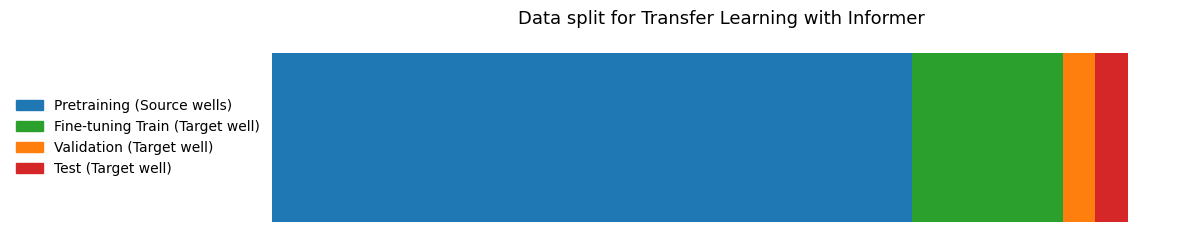

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Ejemplo con tamaños (ajusta con tus datos reales)
n_pretrain = len(pretrain_loader.dataset)
n_train = len(finetune_train_loader.dataset)
n_val = len(finetune_val_loader.dataset)
n_test = len(finetune_test_loader.dataset)

# Longitudes de cada bloque
lengths = [n_pretrain, n_train, n_val, n_test]
colors = ["#1f77b4", "#2ca02c", "#ff7f0e", "#d62728"]
labels = ["Pretraining (Source wells)",
          "Fine-tuning Train (Target well)",
          "Validation (Target well)",
          "Test (Target well)"]

# Gráfico en fila
fig, ax = plt.subplots(figsize=(12, 2.5))

left = 0
for l, c in zip(lengths, colors):
    ax.barh(0, l, left=left, color=c, height=0.5)
    left += l

# Crear leyenda con cuadros de color
patches = [mpatches.Patch(color=c, label=lab) for c, lab in zip(colors, labels)]
ax.legend(handles=patches, loc='center left', bbox_to_anchor=(-0.3, 0.5), frameon=False)

# Estética
ax.set_title("Data split for Transfer Learning with Informer", fontsize=13, pad=15)
ax.set_yticks([])
ax.set_xticks([])
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)

plt.tight_layout()
plt.show()



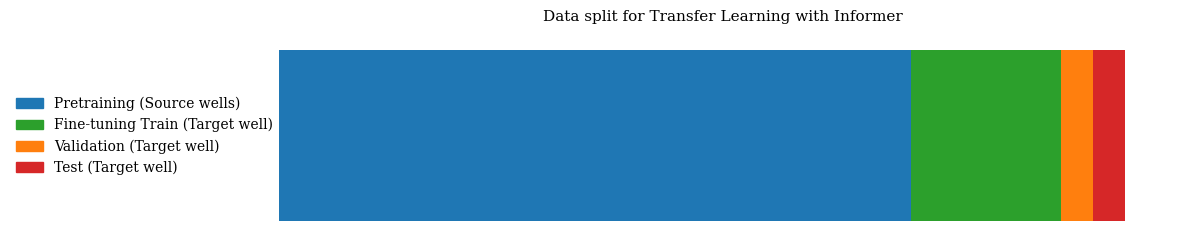

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Datos de ejemplo (ajusta con tus datos reales)
n_pretrain = len(pretrain_loader.dataset)
n_train = len(finetune_train_loader.dataset)
n_val = len(finetune_val_loader.dataset)
n_test = len(finetune_test_loader.dataset)

lengths = [n_pretrain, n_train, n_val, n_test]
colors = ["#1f77b4", "#2ca02c", "#ff7f0e", "#d62728"]
labels = ["Pretraining (Source wells)",
          "Fine-tuning Train (Target well)",
          "Validation (Target well)",
          "Test (Target well)"]

# Configuración de tipografía tipo LaTeX
plt.rcParams.update({
    "font.size": 10,
    "font.family": "serif",
    "axes.titlesize": 11,
    "axes.labelsize": 10
})

# Crear figura
fig, ax = plt.subplots(figsize=(12, 2.5))

left = 0
for l, c in zip(lengths, colors):
    ax.barh(0, l, left=left, color=c, height=0.5)
    left += l

# Leyenda con cuadros de color al lado izquierdo fuera de la figura
patches = [mpatches.Patch(color=c, label=lab) for c, lab in zip(colors, labels)]
ax.legend(handles=patches, loc='center left', bbox_to_anchor=(-0.31, 0.5), frameon=False)

# Estética
ax.set_title("Data split for Transfer Learning with Informer", fontsize=11, pad=15)
ax.set_yticks([])
ax.set_xticks([])
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import math
import numpy as np
from torch.utils.data import Dataset, DataLoader

# ------------------ Positional Encoding ------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

# ------------------ Embedding ------------------
class DataEmbedding(nn.Module):
    def __init__(self, input_size, d_model, dropout=0.1):
        super().__init__()
        self.value_embedding = nn.Linear(input_size, d_model)
        self.position_encoding = PositionalEncoding(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.value_embedding(x)
        x = self.position_encoding(x)
        return self.dropout(x)

# ------------------ ProbSparse Self-Attention ------------------
class ProbSparseSelfAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

    def forward(self, q, k, v):
        B, L, _ = q.size()
        H, D = self.n_heads, self.head_dim

        q = self.q_proj(q).view(B, L, H, D).transpose(1, 2)
        k = self.k_proj(k).view(B, L, H, D).transpose(1, 2)
        v = self.v_proj(v).view(B, L, H, D).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(D)
        top_k = max(1, int(L * 0.1))
        threshold_values, _ = torch.topk(scores, top_k, dim=-1)
        thresholds = threshold_values[..., -1:].expand_as(scores)
        mask = scores >= thresholds

        masked_scores = torch.where(mask, scores, torch.full_like(scores, float('-inf')))
        attn = torch.softmax(masked_scores, dim=-1)
        context = torch.matmul(attn, v)
        context = context.transpose(1, 2).contiguous().view(B, L, H * D)

        return self.out_proj(context)

# ------------------ Encoder ------------------
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=256, dropout=0.1):
        super().__init__()
        self.self_attn = ProbSparseSelfAttention(d_model, n_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x2 = self.norm1(x + self.dropout(self.self_attn(x, x, x)))
        x3 = self.norm2(x2 + self.dropout(self.ffn(x2)))
        return x3

class Encoder(nn.Module):
    def __init__(self, layer, num_layers, d_model, distil=True):
        super().__init__()
        self.layers = nn.ModuleList([layer for _ in range(num_layers)])
        self.distil = distil
        self.pooling = nn.AvgPool1d(kernel_size=2, stride=2) if distil else None
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.distil and i != len(self.layers) - 1:
                x = self.pooling(x.permute(0, 2, 1)).permute(0, 2, 1)
        return self.norm(x)

# ------------------ Decoder ------------------
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=256, dropout=0.05):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, tgt_mask=None):
        x2 = self.norm1(x + self.dropout(self.self_attn(x, x, x, attn_mask=tgt_mask)[0]))
        x3 = self.norm2(x2 + self.dropout(self.cross_attn(x2, memory, memory)[0]))
        x4 = self.norm3(x3 + self.dropout(self.ffn(x3)))
        return x4

class Decoder(nn.Module):
    def __init__(self, layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([layer for _ in range(num_layers)])

    def forward(self, x, memory, tgt_mask=None):
        for layer in self.layers:
            x = layer(x, memory, tgt_mask)
        return x

# ------------------ Informer (dec_x explícito) ------------------
class Informer(nn.Module):
    def __init__(self, input_size, d_model, n_heads, e_layers, d_layers, out_size,
                 label_len=14, pred_len=14, dropout=0.1, distil=True):
        super().__init__()
        self.label_len = label_len
        self.pred_len = pred_len
        self.enc_embedding = DataEmbedding(input_size, d_model, dropout)
        self.dec_embedding = DataEmbedding(input_size, d_model, dropout)
        enc_layer = EncoderLayer(d_model, n_heads, dropout=dropout)
        self.encoder = Encoder(enc_layer, e_layers, d_model, distil=distil)
        dec_layer = DecoderLayer(d_model, n_heads, dropout=dropout)
        self.decoder = Decoder(dec_layer, d_layers)
        self.projection = nn.Linear(d_model, out_size)

    def forward(self, enc_x, dec_x):
        enc_x = self.enc_embedding(enc_x)
        dec_x = self.dec_embedding(dec_x)

        memory = self.encoder(enc_x)
        seq_len = dec_x.size(1)
        tgt_mask = torch.triu(torch.ones(seq_len, seq_len, device=dec_x.device) * float('-inf'), diagonal=1)

        out = self.decoder(dec_x, memory, tgt_mask=tgt_mask)
        out = self.projection(out)

        return out[:, -self.pred_len:, :]

# ------------------ Dataset ------------------
class InformerDataset(Dataset):
    def __init__(self, x_data, y_data, label_len):
        self.x_data = x_data
        self.y_data = y_data
        self.label_len = label_len

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        enc_x = self.x_data[idx]
        dec_len = self.y_data.shape[1]
        input_dim = enc_x.shape[1]

        dec_x = torch.zeros(self.label_len + dec_len, input_dim).float()
        dec_x[:self.label_len] = enc_x[-self.label_len:]

        y = self.y_data[idx]
        return enc_x, dec_x, y

# ------------------ Entrenamiento ------------------
def train_informer(model, train_loader, val_loader, epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for enc_x, dec_x, y in train_loader:
            enc_x, dec_x, y = enc_x.to(device), dec_x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(enc_x, dec_x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for enc_x, dec_x, y in val_loader:
                enc_x, dec_x, y = enc_x.to(device), dec_x.to(device), y.to(device)
                outputs = model(enc_x, dec_x)
                loss = criterion(outputs, y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    return model

# ------------------ Evaluación ------------------
'''def evaluate_informer(model, test_loader, scaler_y):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    preds, trues = [], []
    with torch.no_grad():
        for enc_x, dec_x, y in test_loader:
            enc_x, dec_x, y = enc_x.to(device), dec_x.to(device), y.to(device)
            outputs = model(enc_x, dec_x)
            preds.append(outputs.cpu().numpy())
            trues.append(y.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)

    preds_rescaled = scaler_y.inverse_transform(preds.reshape(-1, 1)).reshape(preds.shape)
    trues_rescaled = scaler_y.inverse_transform(trues.reshape(-1, 1)).reshape(trues.shape)

    mse = np.mean((preds_rescaled - trues_rescaled) ** 2)
    mae = np.mean(np.abs(preds_rescaled - trues_rescaled))
    print(f"✅ Test MSE: {mse:.4f}, MAE: {mae:.4f}")

    return preds_rescaled, trues_rescaled'''
  # ------------------ Evaluación ------------------
def evaluate_informer(model, test_loader, scaler_y):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    preds, trues = [], []
    with torch.no_grad():
        for enc_x, dec_x, y in test_loader:
            enc_x, dec_x, y = enc_x.to(device), dec_x.to(device), y.to(device)
            outputs = model(enc_x, dec_x)
            preds.append(outputs.cpu().numpy())
            trues.append(y.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    trues = np.concatenate(trues, axis=0)

    # Re-escalar
    preds_rescaled = scaler_y.inverse_transform(preds.reshape(-1, 1)).reshape(preds.shape)
    trues_rescaled = scaler_y.inverse_transform(trues.reshape(-1, 1)).reshape(trues.shape)

    # Evitar división por cero en MAPE
    epsilon = 1e-8

    # Media de los reales
    y_mean = np.mean(trues_rescaled)

    # RMSE
    rmse = np.sqrt(np.mean((preds_rescaled - trues_rescaled) ** 2))

    # RSE
    rse = np.sum((preds_rescaled - trues_rescaled) ** 2) / np.sum((trues_rescaled - y_mean) ** 2)

    # RAE
    rae = np.sum(np.abs(preds_rescaled - trues_rescaled)) / np.sum(np.abs(trues_rescaled - y_mean))

    # MAPE (%)
    mape = np.mean(np.abs((preds_rescaled - trues_rescaled) / np.maximum(np.abs(trues_rescaled), epsilon))) * 100
    print(f"✅ RMSE: {rmse:.4f}")
    print(f"✅ RSE:  {rse:.4f}")
    print(f"✅ RAE:  {rae:.4f}")
    print(f"✅ MAPE: {mape:.2f}%")

    return preds_rescaled, trues_rescaled


# ------------------ Flujo completo ------------------
input_size = x_pretrain.shape[2]
out_size = 1

model = Informer(
    input_size=input_size,
    d_model=512,
    n_heads=8,
    e_layers=3,
    d_layers=2,
    out_size=out_size,
    label_len=14,
    pred_len=14,
    dropout=0.1,
    distil=True
)

# Pretraining
print("\n🚀 Pretraining en pozos fuente...")
model = train_informer(model, pretrain_loader, pretrain_loader, epochs=300, lr=1e-4)

# Fine-tuning
print("\n🎯 Fine-tuning en pozo destino...")
model = train_informer(model, finetune_train_loader, finetune_val_loader, epochs=100, lr=5e-5)

# Evaluación
print("\n📊 Evaluación en test (pozo destino)...")
preds, trues = evaluate_informer(model, finetune_test_loader, scaler_y)




🚀 Pretraining en pozos fuente...
Epoch [1/300] | Train Loss: 0.047402 | Val Loss: 0.003254
Epoch [2/300] | Train Loss: 0.007513 | Val Loss: 0.003515
Epoch [3/300] | Train Loss: 0.005720 | Val Loss: 0.003214
Epoch [4/300] | Train Loss: 0.004568 | Val Loss: 0.003016
Epoch [5/300] | Train Loss: 0.004515 | Val Loss: 0.003309
Epoch [6/300] | Train Loss: 0.003807 | Val Loss: 0.007733
Epoch [7/300] | Train Loss: 0.003784 | Val Loss: 0.002595
Epoch [8/300] | Train Loss: 0.003503 | Val Loss: 0.002472
Epoch [9/300] | Train Loss: 0.003092 | Val Loss: 0.002388
Epoch [10/300] | Train Loss: 0.003198 | Val Loss: 0.003413
Epoch [11/300] | Train Loss: 0.003109 | Val Loss: 0.002728
Epoch [12/300] | Train Loss: 0.003046 | Val Loss: 0.002331
Epoch [13/300] | Train Loss: 0.002868 | Val Loss: 0.003573
Epoch [14/300] | Train Loss: 0.002709 | Val Loss: 0.002197
Epoch [15/300] | Train Loss: 0.002702 | Val Loss: 0.002507
Epoch [16/300] | Train Loss: 0.002645 | Val Loss: 0.002194
Epoch [17/300] | Train Loss: 0.

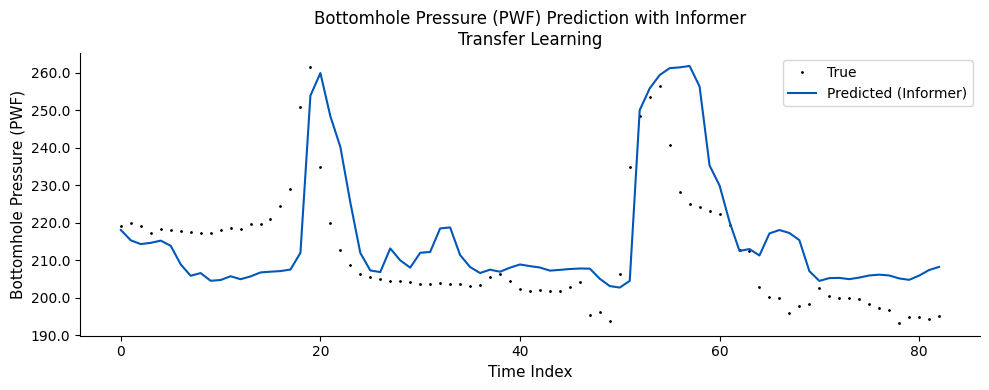

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ✅ Usar los outputs rescalados del modelo
targets_np = trues  # trues_rescaled del evaluate_informer
preds_np = preds    # preds_rescaled del evaluate_informer

# 🚀 Usamos la primera predicción de cada secuencia (pred_len pasos)
targets_1d = targets_np[:, 0]
preds_1d = preds_np[:, 0]

# 🔧 Recortar al mismo largo
min_len = min(len(targets_1d), len(preds_1d))
targets_1d = targets_1d[:min_len]
preds_1d = preds_1d[:min_len]

# 🚫 Opcional: eliminar últimos puntos para claridad
if min_len > 60:
    targets_1d = targets_1d[:-60]
    preds_1d = preds_1d[:-60]

# 📊 Métricas
rmse = np.sqrt(mean_squared_error(targets_1d, preds_1d))
mae = mean_absolute_error(targets_1d, preds_1d)
r2 = r2_score(targets_1d, preds_1d)

# 🎨 Gráfica
plt.figure(figsize=(10, 4))
plt.plot(targets_1d, 'k.', label='True', markersize=2)
plt.plot(preds_1d, label='Predicted (Informer)', color='#0057B7', linestyle='-', linewidth=1.5)

plt.title('Bottomhole Pressure (PWF) Prediction with Informer\nTransfer Learning', fontsize=12)
plt.xlabel('Time Index', fontsize=11)
plt.ylabel('Bottomhole Pressure (PWF)', fontsize=11)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)

# 🔹 Limpieza de bordes
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# 📌 Mostrar métricas en la gráfica
#plt.text(0.02, 0.95, f"RMSE={rmse:.2f}\nMAE={mae:.2f}\nR²={r2:.2f}",
        # transform=ax.transAxes,
         #fontsize=10, verticalalignment='top',
         #bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

plt.tight_layout()
plt.savefig('pwf_informer_transfer.png', dpi=300)
plt.show()
